# Purpose

The purpose of this notebook is to create figures on adoption targeting. The ones we are going for are:

1. Plotting of flows for priority routes TO/FROM the metro. 

The idea we'll pursue is this: for most routes, changing to the metro would reduce overall congestion on the street layer. However, there are some routes for which changing to the metro could have a potentially large NEGATIVE impact on overall congestion. If we'd like these folks to use the metro, then we should put buses there. 

In [1]:
import matplotlib
matplotlib.use('Agg')

% matplotlib inline
import Image
# homebrewed modules
from metro import multiplex as mx
from metro import io            # for reading multiplex
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data
from metro import ita

# other modules
import warnings                 # suppress ipython warnings
import networkx as nx           # assigning attributes to multiplex
import random                   # randomly sample node subsets
import matplotlib.pyplot as plt # convenience for plotting

from matplotlib import pylab    # for colormap manipulation
import numpy as np              # math functions
import igraph
import pandas as pd
import matplotlib.cm as cm
import copy
from copy import deepcopy
import seaborn as sns
sns.set_context("paper")
pylab.rcParams['savefig.dpi'] = 300 # should be ~300 for final figs


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
warnings.filterwarnings('ignore') # stops ipython from printing warnings


In [3]:
df = pd.read_csv('3_throughput/targeted_100.csv')

In [4]:
dg = df[['flow', 'congested_time_m']]

In [5]:
dg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522347 entries, 0 to 4522346
Data columns (total 2 columns):
flow                float64
congested_time_m    float64
dtypes: float64(2)
memory usage: 103.5 MB


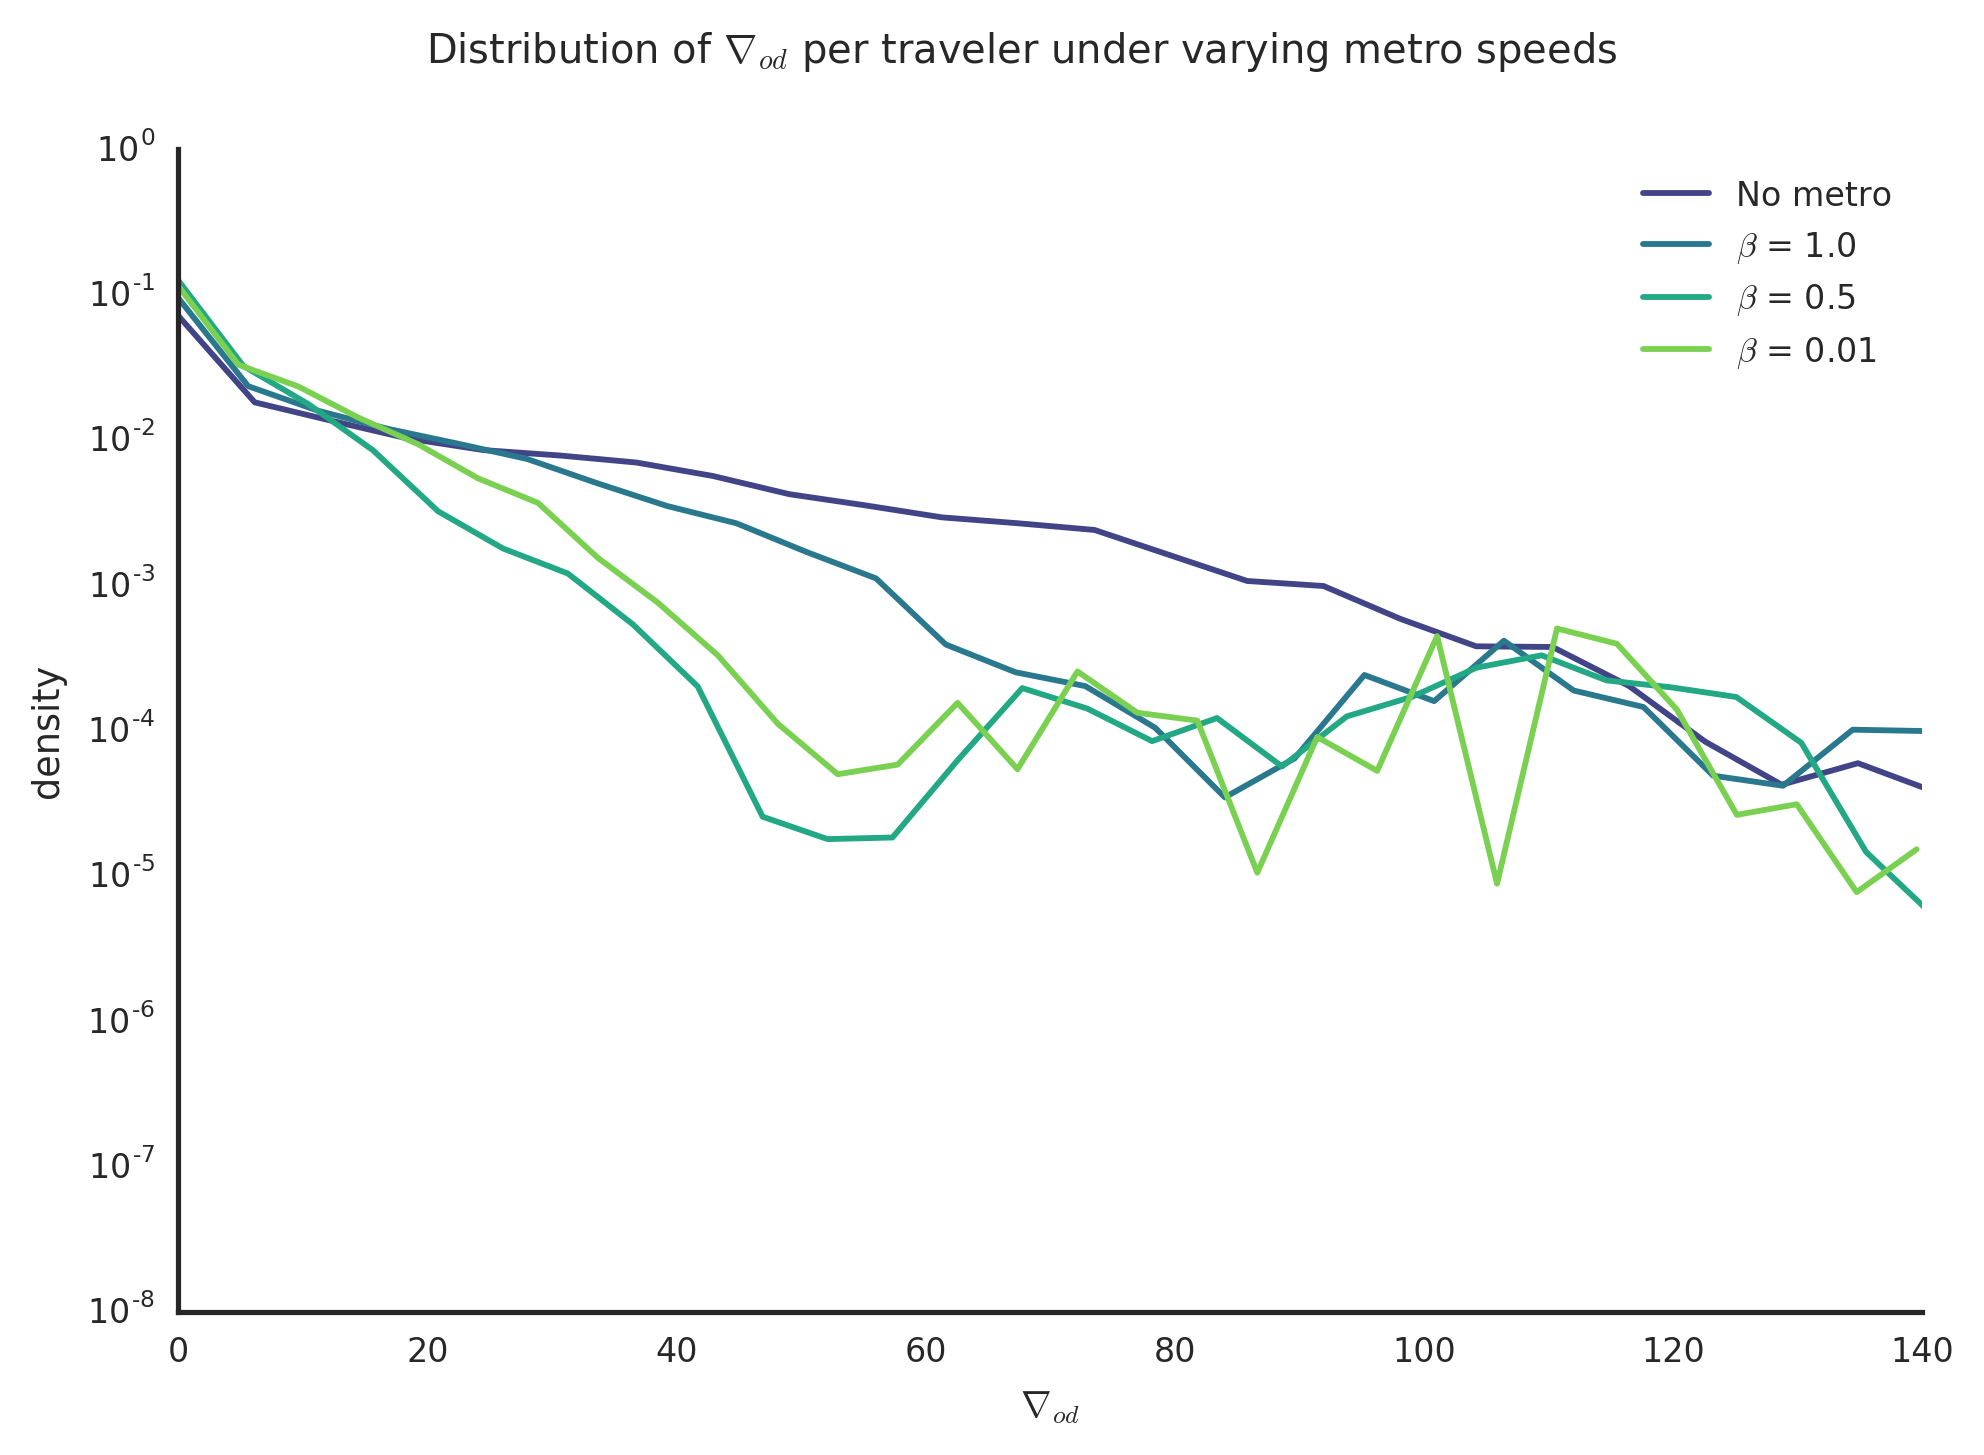

In [6]:
betas = [1000.0, 1.0, 0.5, 0.01]
sns.set_style("white")
sns.set_palette(sns.color_palette("viridis", len(betas)))
current_palette = sns.color_palette()
fig = plt.figure(figsize = (7.5, 5))
ax1 = fig.add_subplot(111)

i = 0
for beta in betas:
    df = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')
    dg = df[df.gamma > 0]
    if beta == 1000.0:
        lab = 'No metro'
    else:
        lab = r'$\beta$ = ' + str(beta)
    viz.weighted_hist(ax = ax1, 
                      measure = dg.gradient, 
                      weights = dg.flow, 
                      label = lab,  
                      standardized = False,
                      color = current_palette[i],
                      n = 30)
    i += 1

ax1.set_yscale('log')
ax1.set(xlabel = r'$\nabla_{od}$', ylabel = 'density', xlim = (0, 140))
ax1.legend()
fig.suptitle(r'Distribution of $\nabla_{od}$ per traveler under varying metro speeds')

sns.despine()

plt.savefig('4_figs/gradient_dist.png')

In [7]:
multi = mx.read_multi(nodes_file_name = '3_throughput/mx_flow_nodes.txt', 
                      edges_file_name = '3_throughput/mx_flow_edges.txt')

In [8]:
dists = nx.get_edge_attributes(multi.G, 'dist_km')
times = nx.get_edge_attributes(multi.G, 'free_flow_time_m')

speed_km_m = {key : dists[key]/times[key] for key in dists}

nx.set_edge_attributes(multi.G, 'speed_km_m', speed_km_m)

street_speed = multi.mean_edge_attr_per(layers = ['streets'], 
                                    attr = 'speed_km_m', 
                                    weight_attr = 'dist_km')

metro_speed = multi.mean_edge_attr_per(layers = ['metro'], 
                                   attr = 'speed_km_m', 
                                   weight_attr = 'dist_km') 

scale = street_speed / metro_speed

multi.scale_edge_attribute(layer = 'metro', 
                       attribute = 'free_flow_time_m', 
                       beta = 1/scale)

In [9]:
def wavg_constructor(col, weight):
    def wavg(group):
        d = group[col]
        w = group[weight]
        return (d * w).sum() / w.sum()
    return wavg

In [10]:
con_map = {int(multi.G.node[n]['con_name']) : n for n in multi.G.node if multi.G.node[n]['layer'] == 'taz'}

center_point = (46.7167, 24.6333)
l = .2

xlim = (center_point[0] - l, center_point[0] + l)
ylim = (center_point[1] - l + .05, center_point[1] + l + .05)

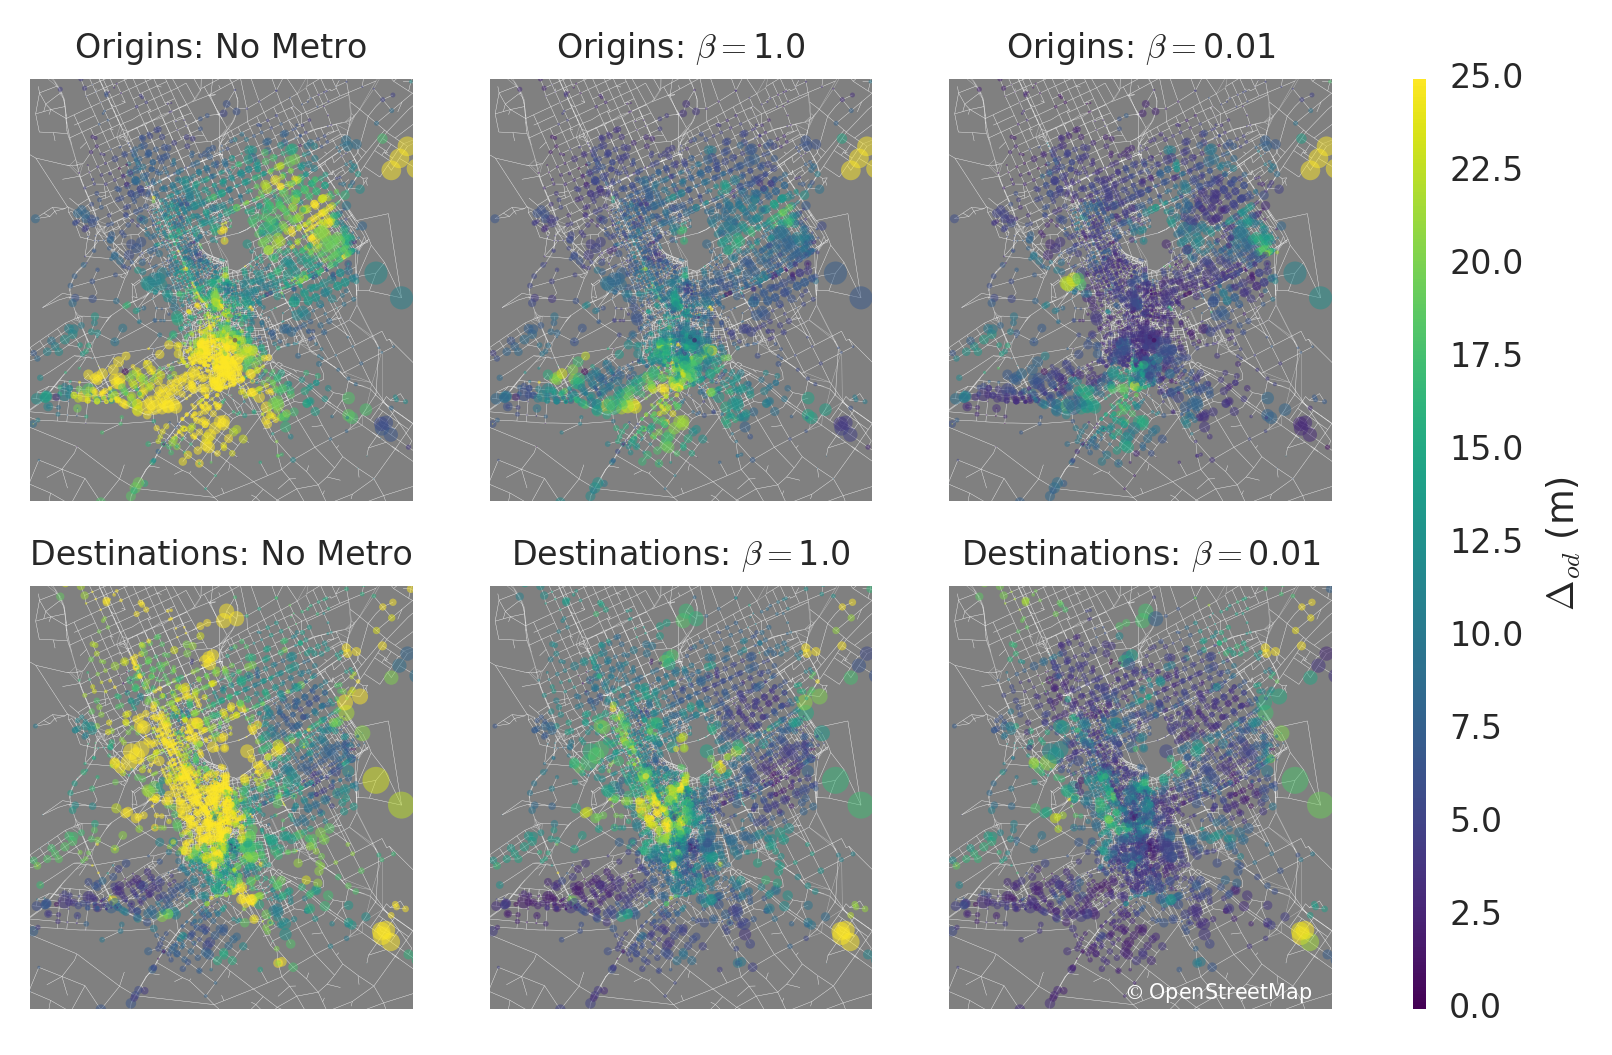

In [19]:
reload(viz)
cmap = 'viridis'
vmax = 25
betas = [1000.0, 1.0, 0.01]

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(7,4))

f.subplots_adjust(hspace=.2, wspace=.2)

for beta, top_ax, bottom_ax in zip(betas, [ax1, ax2, ax3], [ax4, ax5, ax6]):
    
    for line in ['right', 'top', 'bottom', 'left']:
        top_ax.spines[line].set_visible(False)
        bottom_ax.spines[line].set_visible(False)
    
    df = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')
    wavg = wavg_constructor('gradient', 'flow')

    df['o_node'] = df.o_con.apply(con_map.get)
    df['d_node'] = df.d_con.apply(con_map.get)
    o_gradient   = df.groupby('o_node').apply(wavg).to_dict()
    o_flow       = df.groupby('o_node').flow.sum().to_dict()
    d_gradient   = df.groupby('d_node').apply(wavg).to_dict()
    d_flow       = df.groupby('d_node').flow.sum().to_dict()

    attrs = {'o_gradient' : o_gradient, 
             'o_flow'     : o_flow, 
             'd_gradient' : d_gradient, 
             'd_flow'     : d_flow}

    for attr in attrs:
        nx.set_node_attributes(multi.G, attr, 0)
        nx.set_node_attributes(multi.G, attr, attrs[attr])
    
    if beta == 1000.0:
        beta_title = 'No Metro'
    else:
        beta_title = r'$\beta = $' + str(beta)
    
    top_ax.set_title('Origins: ' + beta_title, fontsize = 8)
    bottom_ax.set_title(r'Destinations: ' + beta_title, fontsize = 8)
    i += 1

    viz.bubble_plot(multi.G, 
                    size = 'o_flow', 
                    color = 'o_gradient', 
                    size_factor = 0.01, 
                    vmax = vmax,
                    alpha = .5,
                    cmap = cmap,
                    linewidths = 0,
                    ax = top_ax, )

    viz.bubble_plot(multi.G, 
                    size = 'd_flow', 
                    color = 'd_gradient', 
                    size_factor = 0.01, 
                    vmax = vmax,
                    alpha = .5,
                    cmap = cmap,
                    linewidths = 0,
                    ax = bottom_ax)
   
    top_ax.set(xlim = xlim, ylim = ylim)
    bottom_ax.set(xlim = xlim, ylim = ylim)
    
    top_ax.patch.set_facecolor('grey')
    bottom_ax.patch.set_facecolor('grey')
    
    top_ax.get_xaxis().set_visible(False)
    top_ax.get_yaxis().set_visible(False)
    top_ax.spines.clear()
    
    bottom_ax.get_xaxis().set_visible(False)
    bottom_ax.get_yaxis().set_visible(False)
    bottom_ax.spines.clear()

cols = plt.get_cmap(cmap)
m = cm.ScalarMappable(cmap=cols)
m.set_array([0, vmax])

cax,kw = matplotlib.colorbar.make_axes([ax1, ax2, ax3, ax4, ax5, ax6])
cbar = plt.colorbar(m, cax=cax, **kw)
cbar.set_label(r'$\Delta_{od}$ (m)')

cax.tick_params(axis='y')
cax.set_aspect(75)

cbar.outline.set_linewidth(0)

ax6.text(0.95, 0.01, r'$\copyright$ OpenStreetMap',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax6.transAxes,
        color='white', fontsize=5)

plt.savefig('4_figs/gradient_spatial.tif', bbox_inches = 'tight')
plt.show()

# Simulating targeting scenarios